# Hotswapping LoRA Adapters at Runtime with Transformers


https://medium.com/@coldstart_coder/hot-swapping-lora-adapters-at-runtime-with-transformers-139d628e954f

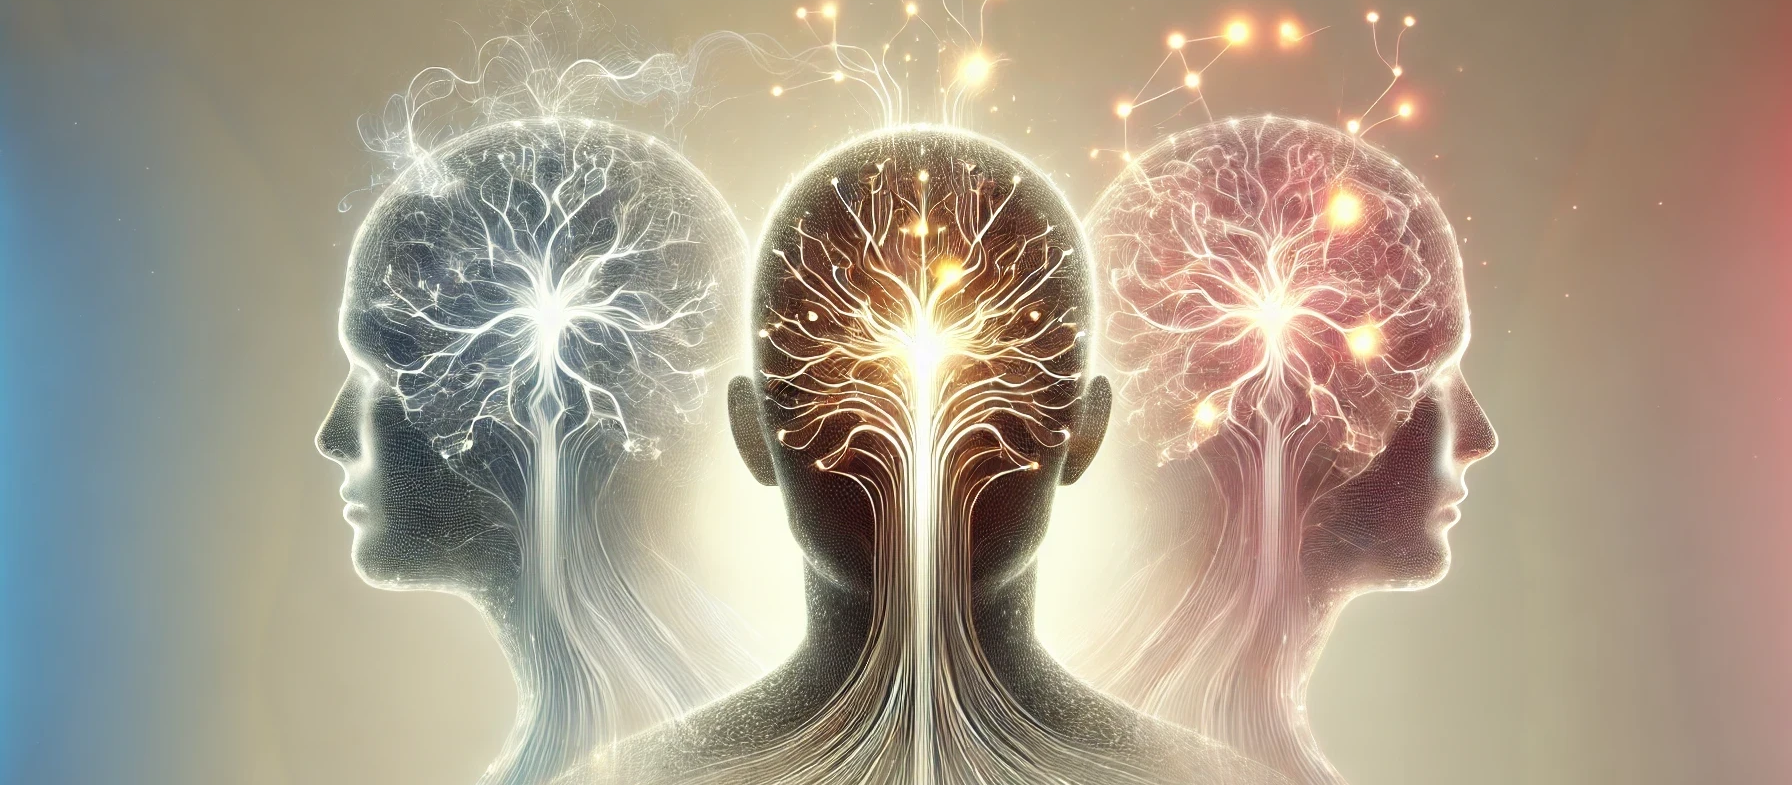

One feature of LoRA that I really like is the ability to hot swap them at runtime. So long as both adapters use the same base model you can load up the base model and then just activate or deactivate which adapter you need at a given time. No need to load or unload a complete model, just the much smaller LoRA weights, and you can completely change how the model behaves. This is an extremely powerful tool, and in the Hugging Face ecosystem is simple to do!

In this notebook I quickly go over how to add multiple adapters to a base model and how to enable and disable them at runtime. We'll be using Llama-3.1-8b-Instruct and 2 adapters I've trained for it that each embed a unique personality into the model. (If you'd like to see how I trained the adapters I've written about the process [here](https://medium.com/@coldstart_coder/using-q-lora-to-embed-a-personality-into-llama-3-1-95f8cf5d22ac) )

## System Environment
Since we're only doing inference for this notebook you don't need an environment with a large amount of resources. For this notebook you will need about 6 gb of GPU RAM, so you should be able to run it comfortably on moderate systems, a T4 will be more than enough. You can even get away with using something like a 4060 that has 8GB.

## Installing Packages
First things first, let's install and update the libraries we'll need.

In [ ]:
!pip install -U transformers peft bitsandbytes

## Environment Setup
Next, since the Llama models are gated, we'll have to authenticate with our access token from Hugging Face before we can download and use the base model. Hugging Face has a helpful notebook_login function that will imbed a html widget where we can paste our token and it will add those to our credentials so we can download the model.

If you need to request access to the Llama 3.1 family of models you can do so [Here](https://huggingface.co/meta-llama/Meta-Llama-3.1-8B-Instruct)

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

## Loading the Model and Adapters
Now let's go through how to load and use the base model and adapters. Before we get started, we'll list what base model and adapters we'll use. For this notebook we'll use Llama-3.1-8B-Instruct and two of my own adapters I've fine-tuned and pushed to HuggingFace. The adapters are tuned to embed a personality into the Llama responses, one for a surfer dude and another for a hillbilly. The fact the personalities are so different from the base model and each other will be perfect to ensure our adapters are getting swapped properly.

In [ ]:
base_model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
surfer_model_id = "Coldstart/Llama-3.1-8B-Instruct-Surfer-Dude-Personality"
hillbilly_model_id = "Coldstart/Llama-3.1-8B-Instruct-Hillbilly-Personality"

First, let's load our base model and tokenizer. We'll load the model with 4-bit quantization to keep our memory requirements low.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id)
model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    device_map="cuda")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

Next, we'll load our adapters. With Transformers models this is extremely easy, we'll call the model's load_adapter function with our adapter id in HuggingFace or with a path to the adapter weights on our system, we'll also define the adapter_name we'll use to identify it with later in code.

Using this we'll load both the surfer and hillbilly adapters.

In [ ]:
model.load_adapter(surfer_model_id, adapter_name="surfer_adapter")
model.load_adapter(hillbilly_model_id, adapter_name="hillbilly_adapter")

adapter_config.json:   0%|          | 0.00/739 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/83.9M [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/739 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/83.9M [00:00<?, ?B/s]

## Enabling and Disabling Adapters
Now that our model and adapters are all loaded, we can start doing inference!

The functions to know are the disable_adapters, enable_adapters, and set_adapter. They're pretty straightforward to use. Let's start with running the model without any adapters and get output just from the base model.

In [ ]:
# disable all adapters so that we just use the base model to get output
model.disable_adapters()

# tokenize a simple message to have the model output about itself.
messages = [{"role": "human", "content": "please introduce yourself and tell the user a bit about what you like to do."}]
token_inputs = tokenizer.apply_chat_template(messages, tokenize=True, return_tensors="pt").to("cuda")

# we'll only generate 100 tokens, we don't need to generate a full message
# just enough to verify what type of output we're getting
token_outputs = model.generate(token_inputs, max_new_tokens=100)

# grab just the new tokens
new_tokens = token_outputs[0][token_inputs.shape[-1]:]

# decode the output and print
decoded_output = tokenizer.decode(new_tokens, skip_special_tokens=True)
print(decoded_output)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


assistant

Hello! I'm an AI, a computer program designed to simulate conversations, answer questions, and provide information on a wide range of topics. I'm often referred to as a "chatbot" or a "virtual assistant."

I don't have personal experiences or emotions like humans do, but I'm designed to be helpful and engaging. I can chat with you about your interests, provide explanations and definitions, or even generate creative content like stories or poems.

I'm a large language


The output is about what we would expect for the base model, so even though our adapters are loaded and on the GPU we can still call just the base model if we need to.

Moving on, let's re-enable the adapters and set the active adapter to our surfer dude. One important note is that we can only have 1 adapter active at a time, so if we enable 1 adapter all other adapters will be disabled.

In [ ]:
# enable the adapters
model.enable_adapters()
# set the active adapter by the id we set when we loaded the model,
# in this case surfer_adapter
model.set_adapter("surfer_adapter")

# tokenize a simple message to have the model output about itself.
messages = [{"role": "human", "content": "please introduce yourself and tell the user a bit about what you like to do."}]
token_inputs = tokenizer.apply_chat_template(messages, tokenize=True, return_tensors="pt").to("cuda")

# we'll only generate 100 tokens, we don't need to generate a full message
# just enough to verify what type of output we're getting
token_outputs = model.generate(token_inputs, max_new_tokens=100)

# grab just the new tokens
new_tokens = token_outputs[0][token_inputs.shape[-1]:]

# decode the output and print
decoded_output = tokenizer.decode(new_tokens, skip_special_tokens=True)
print(decoded_output)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


assistant

Hey dude, I'm like, a chatbot, bro. I'm here to help you out with any questions or stuff you wanna know about. I'm stoked to be talkin' to you and I'm all about learnin' and sharin' knowledge, man. So, like, what's on your mind? Want to know about the best surf spots in Hawaii or something? Just let me know, bro!


Radical! It's clear the adapter is now affecting the output of the model and works perfectly! Now at this point anytime we do inference the surfer adapters will be active and influence the output, until we disable or set a new adapter.

Now let's change the adapter to the hillbilly and do inference again.

In [ ]:
# we already have adapters enabled, so we don't have to call enable_adapters() again
# instead we just need to call set_adapter with a new id, our hillbilly_adapter
model.set_adapter("hillbilly_adapter")

# tokenize a simple message to have the model output about itself.
messages = [{"role": "human", "content": "please introduce yourself and tell the user a bit about what you like to do."}]
token_inputs = tokenizer.apply_chat_template(messages, tokenize=True, return_tensors="pt").to("cuda")

# we'll only generate 100 tokens, we don't need to generate a full message
# just enough to verify what type of output we're getting
token_outputs = model.generate(token_inputs, max_new_tokens=100)

# grab just the new tokens
new_tokens = token_outputs[0][token_inputs.shape[-1]:]

# decode the output and print
decoded_output = tokenizer.decode(new_tokens, skip_special_tokens=True)
print(decoded_output)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


assistant

Shugah, it's high time for me to spin ya a yarn 'bout myself! My name's Bubba, and I'm a fella from down in Dixie, where the sweet tea flows like the crick and the kinfolk are as warm as a summer breeze. Now, I know what you're thinkin', "What in tarnation does Bubba like to do?" Well, let me tell you, boy! I love me some good


Perfect! The surfer is disabled and hillbilly enabled just as we expected.

## Final Thoughts
Adapters are a powerful tool to help us tune how our model behaves, and being able to load multiple adapters and swap between them at runtime without having to load multiple versions of a base model gives us a lot of flexibility when building our projects and solutions. With a single function call we can completely change how our model acts without having to completely load a new model. This is an extremely powerful feature, and in the HuggingFace libraries extremely easy to make use of!

This is extremely beneficial for organizations that need to fine tune a model for multiple use cases and are looking on how to save on latency and/or GPU costs. Tune multiple adapters and just swap them in/out as necessary!

With this we can make better and more robust LLM systems! Exciting stuff!

I hope you were able to find this notebook useful and can see the power of this feature. Happy Coding!
